# Stock Price Difference Prediction

### Data Preparation

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [147]:
FPT,MSN,PNJ,VIC = pd.read_csv("FPT.csv"),pd.read_csv("MSN.csv"),pd.read_csv("PNJ.csv"),pd.read_csv("VIC.csv")

In [148]:
# Create a df with datetime as index and price difference as value
def prep(df):
    # Change date column to appropriate format and make it into index
    df[df.columns[1]] = pd.to_datetime(df[df.columns[1]])
    df.index = df[df.columns[1]]
    
    # Create the price difference column
    df = df.loc[:, df.columns[2:7]]
    df["diff"] = df[df.columns[3]].shift(-1) - df[df.columns[3]]
    
    return df["diff"].dropna()

The function creates a dataframe where each row is the price differrence between the next instance and the current instance.

In [149]:
FPT,MSN,PNJ,VIC = prep(FPT),prep(MSN),prep(PNJ),prep(VIC)

In [410]:
MSN

Date/Time
2017-12-25 09:15:00   -0.1
2017-12-25 09:16:00    0.5
2017-12-25 09:18:00   -0.4
2017-12-25 09:20:00   -0.1
2017-12-25 09:21:00    0.1
                      ... 
2020-12-22 14:22:00    0.0
2020-12-22 14:23:00    0.0
2020-12-22 14:24:00    0.0
2020-12-22 14:25:00    0.0
2020-12-22 14:27:00    0.0
Name: diff, Length: 135353, dtype: float64

In [150]:
# Visualize price difference over time
FPT.plot()

Date/Time
2018-12-25 09:15:00   -0.08
2018-12-25 09:16:00   -0.07
2018-12-25 09:17:00    0.00
2018-12-25 09:18:00    0.00
2018-12-25 09:19:00    0.00
                       ... 
2020-12-22 14:23:00    0.00
2020-12-22 14:24:00    0.00
2020-12-22 14:25:00    0.00
2020-12-22 14:26:00   -0.10
2020-12-22 14:29:00    0.00
Name: diff, Length: 97405, dtype: float64

### Long Short Term Memory

In [183]:
from sklearn.preprocessing import MinMaxScaler

# Split data into train, validate and test set; then scale it
def split_scale(df): 
    # Turn series into arrays
    df = df.to_numpy()
    
    # Create input-output pairs
    X = [] # Input
    y = [] # Output

    time_steps = 60 # Number of previous instances to use as input

    for i in range(time_steps, len(df)):
        X.append(df[i-time_steps:i])
        y.append(df[i])
    X = np.array(X)
    y = np.array(y)
    
    # Split the data (80% train, 10% val, 10% test)
    train_size = int(len(X) * 0.8) 
    val_size = int(len(X) * 0.9)

    X_train = X[:train_size]
    y_train = y[:train_size]

    X_val = X[train_size:val_size]
    y_val = y[train_size:val_size]

    X_test = X[val_size:]
    y_test = y[val_size:]
    
    # Scale the data
    scaler_X = MinMaxScaler(feature_range=(0, 1)) 
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
    X_val_scaled = scaler_X.transform(X_val)
    y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))
    
    return X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled, scaler_X, scaler_y

This function splits the data into train, validate and test set with 80%, 10%, 10% of data respectively.X_train, y_train will be fitted into 2 MinMax Scalers and all data will be transformed accordingly.

In [411]:
# Split and scale data
X_train, y_train, X_val, y_val, X_test, y_test, scaler_X, scaler_y = split_scale(MSN)

In [412]:
# Reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

Data will be reshaped to feed in Long Short Term Memory model.

In [413]:
# Check data shape
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((108234, 60, 1),
 (108234, 1),
 (13529, 60, 1),
 (13529, 1),
 (13530, 60, 1),
 (13530, 1))

In [414]:
# Import Keras modules
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Adam(0.05))

# Fit the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val), verbose=1)

Epoch 1/5
3383/3383 [==============================] - 58s 16ms/step - loss: 6.5714e-04 - val_loss: 1.4539e-04
Epoch 2/5
3383/3383 [==============================] - 54s 16ms/step - loss: 2.5881e-04 - val_loss: 2.4722e-04
Epoch 3/5
3383/3383 [==============================] - 53s 16ms/step - loss: 2.4678e-04 - val_loss: 9.5770e-05
Epoch 4/5
3383/3383 [==============================] - 54s 16ms/step - loss: 2.4412e-04 - val_loss: 9.8825e-05
Epoch 5/5
3383/3383 [==============================] - 53s 16ms/step - loss: 2.4567e-04 - val_loss: 9.4087e-05


In [312]:
from sklearn.metrics import mean_squared_error

# Evaluate the performance of a model on train and validate set using MSE and RMSE
def evaluate(model, X_train, y_train, X_val, y_val):
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    # Inverse transform the predictions and the actual values
    y_pred_train = scaler_y.inverse_transform(y_pred_train.reshape(-1, 1))
    y_train = scaler_y.inverse_transform(y_train.reshape(-1, 1))

    y_pred_val = scaler_y.inverse_transform(y_pred_val.reshape(-1, 1))
    y_val = scaler_y.inverse_transform(y_val.reshape(-1, 1))

    # Calculate the metrics
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)

    mse_val = mean_squared_error(y_val, y_pred_val)
    rmse_val = np.sqrt(mse_val)

    # Print the results
    print('Train MSE: %.5f' % mse_train)
    print('Train RMSE: %.5f' % rmse_train)

    print('Validation MSE: %.5f' % mse_val)
    print('Validation RMSE: %.5f' % rmse_val)
    
    return y_train, y_pred_train, y_val, y_pred_val

This function uses the model to make predictions on X_train and X_val, inversely scales the predictions and evaluates the performance of a model on train and validate set using MSE and RMSE.

In [373]:
# Evaluate the performance of a model on test set using MSE and RMSE
def final(model, X_test, y_test):
    # Make predictions
    y_pred_test = model.predict(X_test)

    # Inverse transform the predictions and the actual values
    y_pred_test = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1))
    y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))
    
    # Calculate the metrics
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    
    # Print the results
    print('Test MSE: %.5f' % mse_test)
    print('Test RMSE: %.5f' % rmse_test)
    
    return y_test, y_pred_test

This function uses the model to make predictions on X_test, inversely scales the predictions and evaluates the performance of a model on test set using MSE and RMSE. This will apply to the model with the highest performance on validate set.

In [415]:
y_train, y_pred_train, y_val, y_pred_val = evaluate(model, X_train, y_train, X_val, y_val)

423/423 [==============================] - 3s 6ms/step
Train MSE: 0.03670
Train RMSE: 0.19158
Validation MSE: 0.01615
Validation RMSE: 0.12707


In [316]:
def visualize(stock, start, end, y_train, y_pred_train, y_val, y_pred_val):
    # Create actual and predicted arrays
    actual = np.concatenate((y_train, y_val))
    pred = np.concatenate((y_pred_train, y_pred_val))
    
    # Reshape data
    actual, pred = np.reshape(actual, -1), np.reshape(pred, -1)
    
    # Create dataframe
    df = pd.DataFrame(data=np.array([actual, pred]).T, columns=['actual', 'pred'])
    df.index = stock.index[:int(len(df))]
    
    # Visualize
    df.iloc[start:end].plot()

This function creates a dataframe with 2 columns: "actual" contains the real data, "pred" contains the predicted data by the model. Then visualize the actual and predicted data from a starting point of time to an ending point of time.

In [370]:
def full_visual(stock, start, end, y_train, y_pred_train, y_val, y_pred_val, y_test, y_pred_test):
    # Create actual and predicted arrays
    actual = np.concatenate((y_train, y_val, y_test))
    pred = np.concatenate((y_pred_train, y_pred_val, y_pred_test))
    
    # Reshape data
    actual, pred = np.reshape(actual, -1), np.reshape(pred, -1)
    
    # Create dataframe
    df = pd.DataFrame(data=np.array([actual, pred]).T, columns=['actual', 'pred'])
    df.index = stock.index[:int(len(df))]
    
    # Visualize
    df.iloc[start:end].plot()

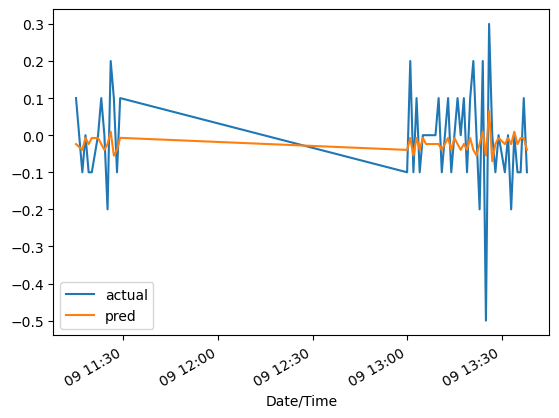

In [416]:
visualize(MSN, 80000, 80050, y_train, y_pred_train, y_val, y_pred_val)

### Random Forest

In [417]:
X_train, y_train, X_val, y_val, X_test, y_test, scaler_X, scaler_y = split_scale(MSN)

In [418]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((108234, 60), (108234, 1), (13529, 60), (13529, 1), (13530, 60), (13530, 1))

In [419]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=6, random_state=42)
rf.fit(X_train, y_train)

D:\Ana\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=10, min_samples_leaf=6, n_estimators=200,
                      random_state=42)

In [420]:
y_train, y_pred_train, y_val, y_pred_val = evaluate(rf, X_train, y_train, X_val, y_val)

Train MSE: 0.03087
Train RMSE: 0.17570
Validation MSE: 0.01480
Validation RMSE: 0.12166


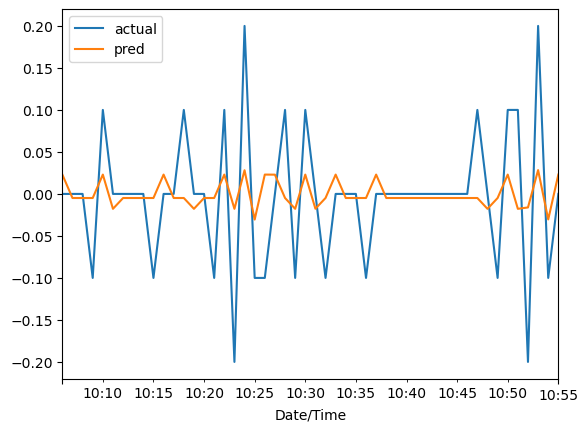

In [422]:
visualize(MSN, 80150, 80200, y_train, y_pred_train, y_val, y_pred_val)

### Gradient Boosting

In [423]:
X_train, y_train, X_val, y_val, X_test, y_test, scaler_X, scaler_y = split_scale(MSN)

In [425]:
from sklearn.ensemble import GradientBoostingRegressor

xgb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=10, 
                          min_samples_leaf=6, random_state=42)
xgb.fit(X_train, y_train)

D:\Ana\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(max_depth=10, min_samples_leaf=6, n_estimators=200,
                          random_state=42)

In [426]:
y_train, y_pred_train, y_val, y_pred_val = evaluate(xgb, X_train, y_train, X_val, y_val)

Train MSE: 0.01623
Train RMSE: 0.12739
Validation MSE: 0.01527
Validation RMSE: 0.12356


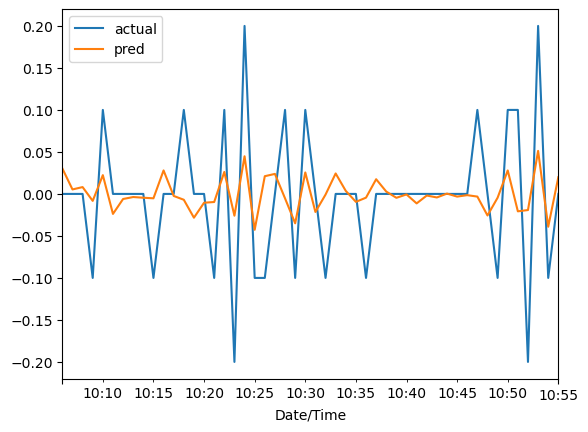

In [427]:
visualize(MSN, 80150, 80200, y_train, y_pred_train, y_val, y_pred_val)

### Fine Tuning Random Forest

Random forest was the best performer among the 3 with a Validation RMSE of 0.06184. Proceed to fine tune the model for best performance.

In [363]:
X_train, y_train, X_val, y_val, X_test, y_test, scaler_X, scaler_y = split_scale(FPT)

In [366]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

# Create hyperparameters
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [10, 20]
min_samples_leaf = [6, 10]
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Create time series split
tscv = TimeSeriesSplit(n_splits=3)

# Build the tuned model
rf2 = RandomForestRegressor(random_state=42)
rf_random = RandomizedSearchCV(rf2, param_distributions = random_grid,
                               n_iter = 3, cv = tscv, verbose=5, scoring='neg_mean_squared_error')

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


D:\Ana\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END bootstrap=True, max_depth=30, min_samples_leaf=10, min_samples_split=10, n_estimators=600;, score=-0.000 total time= 3.1min


D:\Ana\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END bootstrap=True, max_depth=30, min_samples_leaf=10, min_samples_split=10, n_estimators=600;, score=-0.000 total time= 6.5min


D:\Ana\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END bootstrap=True, max_depth=30, min_samples_leaf=10, min_samples_split=10, n_estimators=600;, score=-0.000 total time=10.7min


D:\Ana\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END bootstrap=False, max_depth=70, min_samples_leaf=10, min_samples_split=20, n_estimators=600;, score=-0.000 total time= 6.4min


D:\Ana\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END bootstrap=False, max_depth=70, min_samples_leaf=10, min_samples_split=20, n_estimators=600;, score=-0.001 total time=13.1min


D:\Ana\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END bootstrap=False, max_depth=70, min_samples_leaf=10, min_samples_split=20, n_estimators=600;, score=-0.000 total time=21.5min


D:\Ana\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/3] END bootstrap=False, max_depth=90, min_samples_leaf=6, min_samples_split=20, n_estimators=400;, score=-0.000 total time= 5.1min


D:\Ana\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/3] END bootstrap=False, max_depth=90, min_samples_leaf=6, min_samples_split=20, n_estimators=400;, score=-0.001 total time=10.0min


D:\Ana\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END bootstrap=False, max_depth=90, min_samples_leaf=6, min_samples_split=20, n_estimators=400;, score=-0.000 total time=17.1min


D:\Ana\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=RandomForestRegressor(random_state=42), n_iter=3,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_samples_leaf': [6, 10],
                                        'min_samples_split': [10, 20],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   scoring='neg_mean_squared_error', verbose=5)

In [367]:
import pickle

# Save the model to a file
with open("rf_cv_model.pkl", "wb") as f:
    pickle.dump(rf_random, f)

# Load the model from a file
#with open("rf_cv_model.pkl", "rb") as f:
#    rf_cv = pickle.load(f)

In [371]:
y_train, y_pred_train, y_val, y_pred_val = evaluate(rf_random, X_train, y_train, X_val, y_val)

Train MSE: 0.00271
Train RMSE: 0.05207
Validation MSE: 0.00382
Validation RMSE: 0.06180


In [375]:
y_test, y_pred_test = final(rf_random, X_test, y_test)

Test MSE: 0.00551
Test RMSE: 0.07423


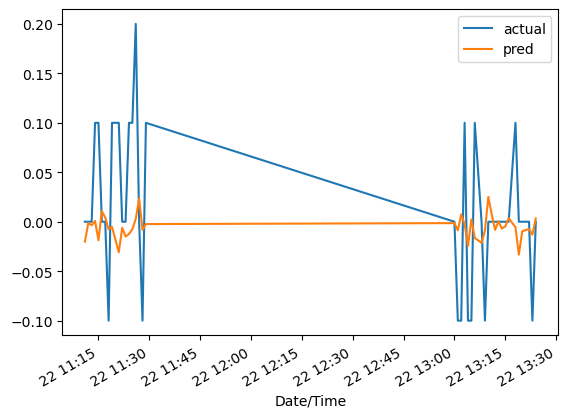

In [382]:
full_visual(FPT, len(FPT) - 100, len(FPT), y_train, y_pred_train, y_val, y_pred_val, y_test, y_pred_test)

### Naive Model Comparison

A naive model predicts the next instance of stock price to be the same as the current instance of stock price, hence the price difference of 0.

In [404]:
X_train, y_train, X_val, y_val, X_test, y_test, scaler_X, scaler_y = split_scale(FPT)

In [407]:
# Naive predictions
y_pred_train = np.array([0] * y_train.shape[0])
y_pred_val = np.array([0] * y_val.shape[0])
y_pred_test = np.array([0] * y_test.shape[0])

# Inverse transform the predictions and the actual values
#y_pred_train = scaler_y.inverse_transform(y_pred_train.reshape(-1, 1))
y_train = scaler_y.inverse_transform(y_train.reshape(-1, 1))

#y_pred_val = scaler_y.inverse_transform(y_pred_val.reshape(-1, 1))
y_val = scaler_y.inverse_transform(y_val.reshape(-1, 1))

#y_pred_test = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1))
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Calculate the metrics
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)

mse_val = mean_squared_error(y_val, y_pred_val)
rmse_val = np.sqrt(mse_val)

mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
    
# Print the results
print('Train MSE: %.5f' % mse_train)
print('Train RMSE: %.5f' % rmse_train)

print('Validation MSE: %.5f' % mse_val)
print('Validation RMSE: %.5f' % rmse_val)

print('Test MSE: %.5f' % mse_test)
print('Test RMSE: %.5f' % rmse_test)

Train MSE: 0.00379
Train RMSE: 0.06157
Validation MSE: 0.00412
Validation RMSE: 0.06415
Test MSE: 0.00585
Test RMSE: 0.07649


Our model has performed better than a naive model.